In [1]:
from pathlib import Path
from datetime import datetime
import json
import simplejson

EXPERIMENT_FOLDER = "./experiments/channel_permutation_test"
Path(EXPERIMENT_FOLDER).mkdir(exist_ok=True)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.reset_defaults()
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [4]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.meta_experiment import *
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Load Data:

In [5]:
NUM_CLASSES = 3
BATCH_SIZE = 32
CHANNEL_SIZE = 5

TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [6]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

# Run Experiments

In [7]:
def create_channel_permutation_experiment(channel_size=5, epochs=200, **exp_kwargs):
    
    agent = Agent(channel_size, NUM_CLASSES)

    start_temp = 10
    end_temp = 0.1
    temp_anneal_end_epoch = 200
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': channel_size,
            'p_mutate': 0,
            'message_permutation': True,
            'channel_temp': channel_temp,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=10,
        **exp_kwargs
    )

In [8]:
permutation_experiment = MetaExperiment(
    create_experiment_fn=create_channel_permutation_experiment,
    num_experiments=2,
    epochs=200,
    export_location=None,
)

In [9]:
games_played, _ = permutation_experiment.experiments[0]['experiment'].run_tests()

In [10]:
permutation_experiment.experiments[0]['experiment'].student.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1664      
_________________________________________________________________
lstm (LSTM)                  multiple                  49408     
_________________________________________________________________
dense_1 (Dense)              multiple                  520       
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0     

In [11]:
permutation_experiment.run()

Running meta_experiment...
Running experiment 1 (0/2 complete):
Run Stopped.


IndexError: list index out of range

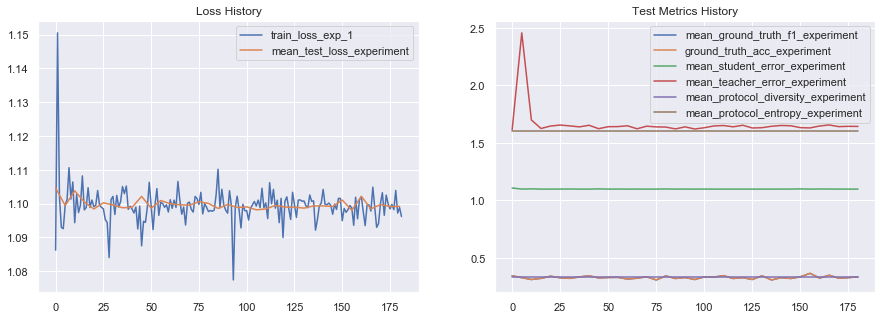

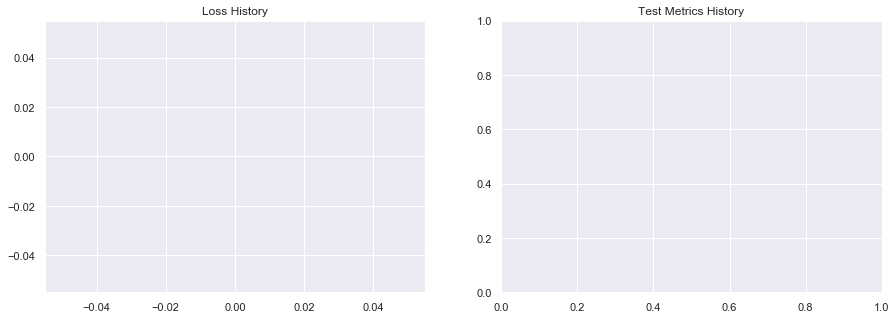

In [12]:
for item in permutation_experiment.experiments:
    item['experiment'].plot_training_history()
plt.show()

In [ ]:
print('After training', len(permutation_experiment.experiments), 'agents we ran', 
      2*len(permutation_experiment.results), '"stranger-encounters"',
      'with the follow zero-shot coordination results:')
permutation_experiment.print_results()

In [ ]:
zs_results = [
    metrics['mean_ground_truth_f1']
    for stranger_pairings in permutation_experiment.results
    for metrics in stranger_pairings['vanilla_params_test_metrics']
]
print('Final mean zero-shot test performance: ', 
      round(float(np.mean(zs_results)), 4), '+-', 
      round(float(np.std(zs_results)), 4))

In [ ]:
for item in permutation_experiment.experiments:
    if item['status'] == 'Complete':
        total_time = sum([
            x['seconds_taken']
            for x in item['experiment'].training_history
        ])
        print(int(total_time / 3600), 'hours,', int(total_time / 60), 'mins and', 
              int(total_time) % 60, 'seconds taken for experiment', item['index'])

In [ ]:
res_path = Path(f'{EXPERIMENT_FOLDER}/results.json')
with res_path.open(mode='w') as f:
    json.dump({'zero_shot_coordination_scores': permutation_experiment.results}, f)

In [ ]:
permutation_experiment.experiments

## Analyse Results

In [ ]:
def load_channel_permutation_experiment(path):
    
    config = json.load((path / 'config.json').open(mode='r'))
    results = json.load((path / 'results.json').open(mode='r'))
    history = json.load((path / 'training_history.json').open(mode='r'))
    
    agent = Agent(config['play_params']['channel_size'], NUM_CLASSES)
    agent.load_weights(str(path / 'agent_weights'))
    
    config['loss_fn'] = student_pred_matches_test_class
    
    kwargs = {
        k: v for k, v in config.items()
        if k not in ['epochs_optimised', 
                     'optimiser_config',
                     'optimise_agents_separately']
    }
    experiment = Experiment(
        generate_train_batch, generate_test_batch,
        student=agent,
        teacher=agent,
        **kwargs
    )
    experiment.epoch = config['epochs_optimised']
    experiment.training_history = history
    experiment.results = results
    
    return experiment

In [ ]:
experiments = []
for path in Path(EXPERIMENT_FOLDER).glob('*'):
    if not path.is_file():
        exp = load_channel_permutation_experiment(path)
        experiments.append(exp)
        print('Loaded experiment from:', path)

In [ ]:
def did_converge_to_global_optima(experiment):
    return experiment.results['mean_ground_truth_f1'] > 0.9

def did_converge_to_local_optima(experiment):
    return 0.9 > experiment.results['mean_ground_truth_f1'] > 0.6

def get_category(experiment):
    if did_converge_to_global_optima(experiment):
        return 'Coverged to Global Optima'
    if did_converge_to_local_optima(experiment):
        return 'Coverged to Local Optima'
    return 'Did Not Converge'

In [ ]:
sns.reset_defaults()
sns.set()

In [ ]:
item['experiment'].training_history[-1]

In [ ]:
df_train = pd.DataFrame([
    {
        'Epoch': epoch,
        'Loss': train_item['loss'],
        'Experiment': f"Run {index}",
        'Category': get_category(experiment)
    }
    for index, experiment in enumerate(permutation_experiment.)
    for epoch, train_item in enumerate(experiment.training_history)
])

df_test = pd.DataFrame([
    {
        'Epoch': epoch,
        'Performance': train_item['test_metrics']['mean_ground_truth_f1'],
        'Protocol Diversity': train_item['test_metrics']['mean_protocol_diversity'],
        'Experiment': f"Run {index}",
        'Category': get_category(experiment)
    }
    for index, experiment in enumerate(permutation_experiment)
    for epoch, train_item in enumerate(experiment.training_history)
    if 'test_metrics' in train_item
])


fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()
sns.lineplot(x='Epoch', y='Loss', data=df_train, label='Train Loss', ax=ax);
sns.lineplot(x='Epoch', y='Performance', data=df_test, label='Test Performance', ax=ax);
sns.lineplot(x='Epoch', y='Protocol Diversity', data=df_test, label='Protocol Diversity', ax=ax);
plt.ylabel('')
plt.title('Channel Permutation Training Histories')
plt.show()

In [ ]:
games_played, _ = experiments[0].run_tests()

In [ ]:
for i in range(5):
    inputs, targets, outputs = games_played[i]
    plot_game(inputs, outputs, targets, select_batch=0)

In [ ]:
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [ ]:
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');